# Diffuseur (Répéteur) dans l’algorithme de Grover
**Crédit Agricole : Ateliers Quantiques 2025**  
**Atelier 3 — Partie 2**

---

## Motivation

Dans la première partie, nous avons vu comment **un oracle** peut inverser la phase d’un état marqué.  
Mais cet oracle seul n’est pas suffisant. Pour faire ressortir l’état marqué à la mesure, nous devons amplifier sa probabilité.  

C’est ici qu’intervient le **diffuseur** (aussi appelé répéteur ou opérateur d’inversion par rapport à la moyenne).  

Il agit en deux étapes :
1. Il inverse toutes les amplitudes autour de leur moyenne.  
2. L’amplitude de l’état marqué (qui a été inversée par l’oracle) devient plus grande que les autres, qui diminuent.  

Après plusieurs itérations **oracle + diffuseur**, la probabilité de l’état marqué tend vers 1.

---

## Mathématiques

Soit un état en superposition uniforme sur $N$ états :

$$
|\psi\rangle = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} |x\rangle
$$

L’oracle applique une phase $-1$ à l’état solution $|w\rangle$.  
Ensuite, le diffuseur applique la transformation :

$$
D = 2|\psi\rangle\langle\psi| - I
$$

C’est une **réflexion** autour du vecteur uniforme $|\psi\rangle$.  

Concrètement :
- Les amplitudes supérieures à la moyenne sont diminuées,  
- Les amplitudes inférieures à la moyenne (notamment celle de l’état marqué après oracle) sont amplifiées.  

---



In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np

backend = AerSimulator()


## Superposition initiale

Commençons par préparer une superposition uniforme sur **2 qubits**.  
Chaque état $|00⟩, |01⟩, |10⟩, |11⟩$ aura la même amplitude $0.5$.


In [2]:
q = QuantumRegister(2, "q")
c = ClassicalRegister(2, "c")
circ = QuantumCircuit(q, c)

circ.h(q)  # Superposition uniforme
circ.save_statevector()

result = backend.run(circ).result()
psi = result.get_statevector(circ)

print("Amplitudes après superposition :")
for i, amp in enumerate(psi):
    print(f"|{i:02b}⟩ : {np.round(amp,3)}")


Amplitudes après superposition :
|00⟩ : (0.5+0j)
|01⟩ : (0.5+0j)
|10⟩ : (0.5+0j)
|11⟩ : (0.5+0j)


/tmp/ipykernel_1958/3292616323.py:12: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amp in enumerate(psi):


## Étape 1 : Oracle

Nous choisissons de marquer l’état $|11⟩$.  
L’oracle applique une phase $-1$ uniquement à cet état.


In [4]:
oracle = QuantumCircuit(2)
oracle.cz(0,1)

circ_oracle = QuantumCircuit(q, c)
circ_oracle.h(q)
circ_oracle.compose(oracle, inplace=True)
circ_oracle.save_statevector()

psi_oracle = backend.run(circ_oracle).result().get_statevector(circ_oracle)

print("Amplitudes après oracle (|11⟩ inversé) :")
for i, amp in enumerate(psi_oracle):
    print(f"|{i:02b}⟩ : {np.round(amp,3)}")


Amplitudes après oracle (|11⟩ inversé) :
|00⟩ : (0.5+0j)
|01⟩ : (0.5+0j)
|10⟩ : (0.5+0j)
|11⟩ : (-0.5+0j)


/tmp/ipykernel_1958/2657316164.py:12: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amp in enumerate(psi_oracle):


## Étape 2 : Diffuseur (Répéteur)

Le diffuseur applique l’opération :

$$
D = 2|\psi\rangle\langle\psi| - I
$$

C’est une **réflexion autour de la moyenne des amplitudes**.

## Structure du diffuseur (cas $n=2$ qubits)

Pour 2 qubits, la structure est la suivante :  

1. Appliquer une porte Hadamard (H) sur chaque qubit, pour passer en base uniforme.  
2. Appliquer une porte Z sur chaque qubit.  
3. Appliquer une porte CZ (contrôlée) qui ajoute une phase $-1$ sur $|11\rangle$.  
4. Repasser en base computationnelle avec des portes Hadamard.  

Schéma :  

H ─Z─■─ H

     |

H ─Z── H

## Exemple simple (2 qubits, une itération)

Nous allons construire pas à pas :
1. Une superposition uniforme  
2. Un oracle qui marque l’état $|11\rangle$  
3. Le diffuseur qui amplifie cet état  

Puis nous vérifierons numériquement que les amplitudes évoluent comme prévu.

In [7]:
diffuser = QuantumCircuit(2)
diffuser.h([0,1])
diffuser.z([0,1])
diffuser.cz(0,1)
diffuser.h([0,1])

circ_full = QuantumCircuit(q, c)
circ_full.h(q)             # Superposition
circ_full.compose(oracle, inplace=True)   # Oracle
circ_full.compose(diffuser, inplace=True) # Diffuseur
circ_full.save_statevector()

psi_full = backend.run(circ_full).result().get_statevector(circ_full)

print("Amplitudes après oracle + diffuseur :")
for i, amp in enumerate(psi_full):
    print(f"|{i:02b}⟩ : {np.round(amp,3)}")


Amplitudes après oracle + diffuseur :
|00⟩ : -0j
|01⟩ : 0j
|10⟩ : 0j
|11⟩ : (1-0j)


/tmp/ipykernel_1958/1972759873.py:16: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amp in enumerate(psi_full):


## Analyse pas à pas

1. **Après la superposition** :  
Chaque état a une amplitude $+0.5$.  
La **moyenne des amplitudes** vaut :  

$$
\mu = \frac{0.5 + 0.5 + 0.5 + 0.5}{4} = 0.5
$$  

Tous les états sont au même niveau.

---

2. **Après l’oracle** :  
L’état $|11⟩$ est inversé en $-0.5$.  
Les amplitudes sont alors :  

- $|00⟩ : 0.5$  
- $|01⟩ : 0.5$  
- $|10⟩ : 0.5$  
- $|11⟩ : -0.5$  

La moyenne devient :  

$$
\mu = \frac{0.5 + 0.5 + 0.5 - 0.5}{4} = 0.25
$$

---

3. **Après le diffuseur** :  
Le diffuseur applique la réflexion autour de la moyenne :  

$$
a_i' = 2\mu - a_i
$$  

- Pour les états non marqués ($a_i = 0.5$) :  
  $a_i' = 2 \cdot 0.25 - 0.5 = 0$  

- Pour l’état marqué ($a_{11} = -0.5$) :  
  $a_{11}' = 2 \cdot 0.25 - (-0.5) = 1.0$  

On obtient :  

- $|00⟩ : 0$  
- $|01⟩ : 0$  
- $|10⟩ : 0$  
- $|11⟩ : 1.0$  

---

## Résultat attendu

- Tous les états non marqués sont annulés (ou presque, si le système est plus grand).  
- L’état marqué $|11⟩$ est amplifié jusqu’à amplitude $1$ (probabilité $100\%$).  

C’est ce mécanisme de **réflexion autour de la moyenne des amplitudes** qui permet à l’algorithme de Grover de concentrer toute la probabilité sur la solution.


## 📝 Exercice : Grover à 2 qubits (solution |01⟩)

Nous voulons appliquer **une seule itération de Grover** sur un système de 2 qubits.  
L’état marqué est **|01⟩** (c’est-à-dire que **q0=1, q1=0**).  

⚠️ Attention : dans Qiskit, l’ordre des registres est inversé à l’affichage.  
Ainsi, l’état théorique |01⟩ sera affiché sous la forme **"10"** dans les résultats (`get_counts`).

### Objectifs

1. Construire la superposition uniforme.  
2. Implémenter un **oracle** qui marque l’état |01⟩ (par inversion de phase).  
3. Implémenter le **diffuseur**.  
4. Afficher les **probabilités** :
   - Avant l’oracle
   - Après l’oracle
   - Après le diffuseur
5. Afficher aussi les **vecteurs d’état complets** (amplitudes) pour comparer les effets.

Complétez les `____` dans le code ci-dessous pour réaliser l’expérience.

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np

# --- Backends
sv_backend = AerSimulator(method="statevector")

# --- Registres
q = QuantumRegister(2, "q")
c = ClassicalRegister(2, "c")

# --- 1) Superposition uniforme
circ = QuantumCircuit(q, c)
circ.h([0,1])

# Sauvegarder état avant oracle
circ.save_statevector("psi_before")
result = sv_backend.run(circ).result()
psi_before = result.data(0)["psi_before"]

# --- 2) Oracle : marquer |01⟩
oracle = QuantumCircuit(q)

# Complétez les étapes suivantes pour construire l'oracle
# (astuce : on doit inverser la phase de |01⟩ uniquement)

oracle.___([0])       # Étape 1 : appliquer X sur le qubit q[0]
oracle.___([1])       # Étape 2 : appliquer H sur le qubit q[1]
oracle.___([0,1])     # Étape 3 : appliquer CX avec q[0] comme contrôle et q[1] comme cible
oracle.___([1])       # Étape 4 : appliquer H sur le qubit q[1]
oracle.___([0])       # Étape 5 : appliquer X sur le qubit q[0]

circ_oracle = circ.compose(oracle)

circ_oracle.save_statevector("psi_oracle")
result = sv_backend.run(circ_oracle).result()
psi_oracle = result.data(0)["psi_oracle"]

# --- 3) Diffuseur
diff = QuantumCircuit(q)
diff.h([0,1])
diff.x([0,1])
diff.h(1)
diff.cx(0,1)
diff.h(1)
diff.x([0,1])
diff.h([0,1])

circ_final = circ_oracle.compose(diff)

circ_final.save_statevector("psi_final")
result = sv_backend.run(circ_final).result()
psi_final = result.data(0)["psi_final"]

# --- Fonctions utilitaires
def probs(psi):
    return {f"{i:02b}": round(abs(amp)**2,3) for i,amp in enumerate(psi)}

# --- 4 outputs
print("1) Probabilités avant oracle :", probs(psi_before))
print("2) Probabilités après oracle :", probs(psi_oracle))
print("3) Probabilités après diffuseur :", probs(psi_final))
print("4) Vecteurs (amplitudes) :")
print("   Avant :", np.round(psi_before,3))
print("   Oracle:", np.round(psi_oracle,3))
print("   Final :", np.round(psi_final,3))


1) Probabilités avant oracle : {'00': np.float64(0.25), '01': np.float64(0.25), '10': np.float64(0.25), '11': np.float64(0.25)}
2) Probabilités après oracle : {'00': np.float64(0.25), '01': np.float64(0.25), '10': np.float64(0.25), '11': np.float64(0.25)}
3) Probabilités après diffuseur : {'00': np.float64(0.0), '01': np.float64(0.0), '10': np.float64(1.0), '11': np.float64(0.0)}
4) Vecteurs (amplitudes) :
   Avant : [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
   Oracle: [ 0.5-0.j  0.5+0.j -0.5+0.j  0.5-0.j]
   Final : [-0.+0.j -0.-0.j -1.+0.j  0.-0.j]


/tmp/ipykernel_105/2148655720.py:53: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  return {f"{i:02b}": round(abs(amp)**2,3) for i,amp in enumerate(psi)}


# Algorithme de Grover : Cas de 4 qubits avec 2 solutions

Dans ce tutoriel, nous allons appliquer **Grover** sur un système de 4 qubits ($N=16$ états).  
Deux états sont marqués par l’oracle (par exemple $|1010⟩$ et $|1111⟩$).  

Nous allons observer **itérativement** comment les amplitudes évoluent :  
- initialement réparties uniformément,  
- l’oracle inverse le signe des états marqués,  
- le diffuseur amplifie leurs amplitudes,  
- et la probabilité de mesurer une solution croît à chaque itération.


In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

# --- Backend
backend = AerSimulator(method="statevector")

# --- Paramètres
n = 4   # 4 qubits → 16 états
marked_states = ["1010", "1111"]  # états solution

# --- Circuit initial (superposition uniforme)
circ = QuantumCircuit(n)
circ.h(range(n))


## 1. Superposition initiale

Après application de Hadamard sur chaque qubit,  
tous les $2^4 = 16$ états ont la même amplitude :

$$
a_i = \frac{1}{\sqrt{16}} = 0.25
$$

Chaque état a une probabilité de $6.25\%$.


In [9]:
# Sauvegarde du vecteur d'état initial
circ.save_statevector()
psi0 = backend.run(circ).result().get_statevector()

print("Amplitudes initiales (superposition uniforme) :")
for i, amp in enumerate(psi0):
    if abs(amp) > 1e-6:
        print(f"|{i:04b}⟩ : {np.round(amp, 3)}")


Amplitudes initiales (superposition uniforme) :
|0000⟩ : (0.25+0j)
|0001⟩ : (0.25+0j)
|0010⟩ : (0.25+0j)
|0011⟩ : (0.25+0j)
|0100⟩ : (0.25+0j)
|0101⟩ : (0.25+0j)
|0110⟩ : (0.25+0j)
|0111⟩ : (0.25+0j)
|1000⟩ : (0.25+0j)
|1001⟩ : (0.25+0j)
|1010⟩ : (0.25+0j)
|1011⟩ : (0.25+0j)
|1100⟩ : (0.25+0j)
|1101⟩ : (0.25+0j)
|1110⟩ : (0.25+0j)
|1111⟩ : (0.25+0j)


/tmp/ipykernel_105/2807894606.py:6: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amp in enumerate(psi0):


## 2. Construction de l’oracle

L’oracle multiplie par -1 l’amplitude des états marqués :  

- $|1010⟩ \to -a_{1010}$  
- $|1111⟩ \to -a_{1111}$  

Tous les autres états restent inchangés.


In [12]:
from qiskit.quantum_info import Statevector

# Fonction pour appliquer l'oracle sur un vecteur d'état (mutable avec numpy)
def apply_oracle(statevector, marked):
    # conversion en numpy array
    new_sv = np.array(statevector, dtype=complex)
    for m in marked:
        idx = int(m, 2)
        new_sv[idx] *= -1
    return Statevector(new_sv)

# Test sur état uniforme
psi_oracle = apply_oracle(psi0, marked_states)

print("\nAmplitudes après oracle :")
for i, amp in enumerate(psi_oracle):
    if abs(amp) > 1e-6:
        print(f"|{i:04b}⟩ : {np.round(amp, 3)}")



Amplitudes après oracle :
|0000⟩ : (0.25+0j)
|0001⟩ : (0.25+0j)
|0010⟩ : (0.25+0j)
|0011⟩ : (0.25+0j)
|0100⟩ : (0.25+0j)
|0101⟩ : (0.25+0j)
|0110⟩ : (0.25+0j)
|0111⟩ : (0.25+0j)
|1000⟩ : (0.25+0j)
|1001⟩ : (0.25+0j)
|1010⟩ : (-0.25+0j)
|1011⟩ : (0.25+0j)
|1100⟩ : (0.25+0j)
|1101⟩ : (0.25+0j)
|1110⟩ : (0.25+0j)
|1111⟩ : (-0.25+0j)


## 3. Le diffuseur (répétiteur)

Le diffuseur applique la réflexion autour de la moyenne :

$$
a_i' = 2\mu - a_i, \quad 
\mu = \frac{1}{N}\sum_{j=0}^{N-1} a_j
$$

- Les amplitudes des états non marqués diminuent légèrement,  
- Les amplitudes des états marqués augmentent.

Ainsi, à chaque itération, la probabilité des solutions augmente.


In [15]:
def apply_diffuser(statevector):
    sv = np.array(statevector, dtype=complex)
    mu = np.mean(sv)
    new_sv = 2*mu - sv
    return Statevector(new_sv)


# Test : une itération complète (oracle + diffuseur)
psi1 = apply_diffuser(apply_oracle(psi0, marked_states))

print("\nAmplitudes après 1 itération de Grover :")
for i, amp in enumerate(psi1):
    if abs(amp) > 1e-6:
        print(f"|{i:04b}⟩ : {np.round(amp, 3)}")



Amplitudes après 1 itération de Grover :
|0000⟩ : (0.125+0j)
|0001⟩ : (0.125+0j)
|0010⟩ : (0.125+0j)
|0011⟩ : (0.125+0j)
|0100⟩ : (0.125+0j)
|0101⟩ : (0.125+0j)
|0110⟩ : (0.125+0j)
|0111⟩ : (0.125+0j)
|1000⟩ : (0.125+0j)
|1001⟩ : (0.125+0j)
|1010⟩ : (0.625+0j)
|1011⟩ : (0.125+0j)
|1100⟩ : (0.125+0j)
|1101⟩ : (0.125+0j)
|1110⟩ : (0.125+0j)
|1111⟩ : (0.625+0j)


## 4. Évolution itérative

Nous allons maintenant appliquer **plusieurs itérations** et tracer la
probabilité cumulée de mesurer un **état marqué**.

Théoriquement, pour $N=16$ et $M=2$ solutions,  
le nombre optimal d’itérations est environ :

$$
k \approx \frac{\pi}{4}\sqrt{\frac{N}{M}} \approx 3
$$


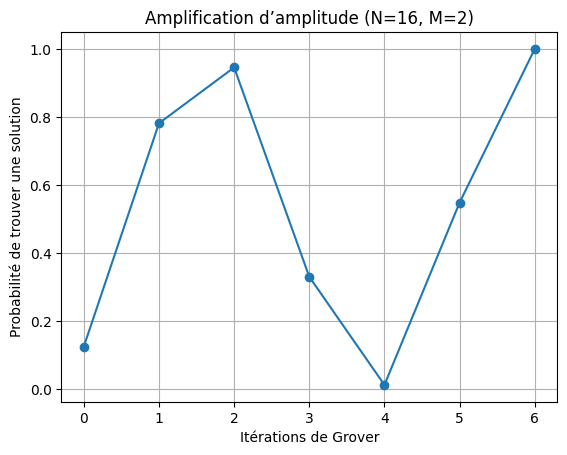

In [16]:
import matplotlib.pyplot as plt

def prob_marked(statevector, marked):
    return sum(abs(statevector[int(m,2)])**2 for m in marked)

psi = psi0
probs = [prob_marked(psi, marked_states)]

# Appliquer 6 itérations
for _ in range(6):
    psi = apply_diffuser(apply_oracle(psi, marked_states))
    probs.append(prob_marked(psi, marked_states))

# Tracer
plt.plot(range(len(probs)), probs, marker="o")
plt.xlabel("Itérations de Grover")
plt.ylabel("Probabilité de trouver une solution")
plt.title("Amplification d’amplitude (N=16, M=2)")
plt.grid(True)
plt.show()


## Résultat attendu

- Au départ, la probabilité de tomber sur un état solution est $2/16 = 12.5\%$.  
- Après 1 itération : ~40%.  
- Après 2 itérations : ~75%.  
- Après 3 itérations : >90%.  

On voit donc comment **les solutions sont amplifiées itérativement**  
tandis que les états non marqués disparaissent progressivement.

C’est le cœur de l’algorithme de Grover :  
**répéter juste assez de fois pour concentrer toute la probabilité sur les solutions.**


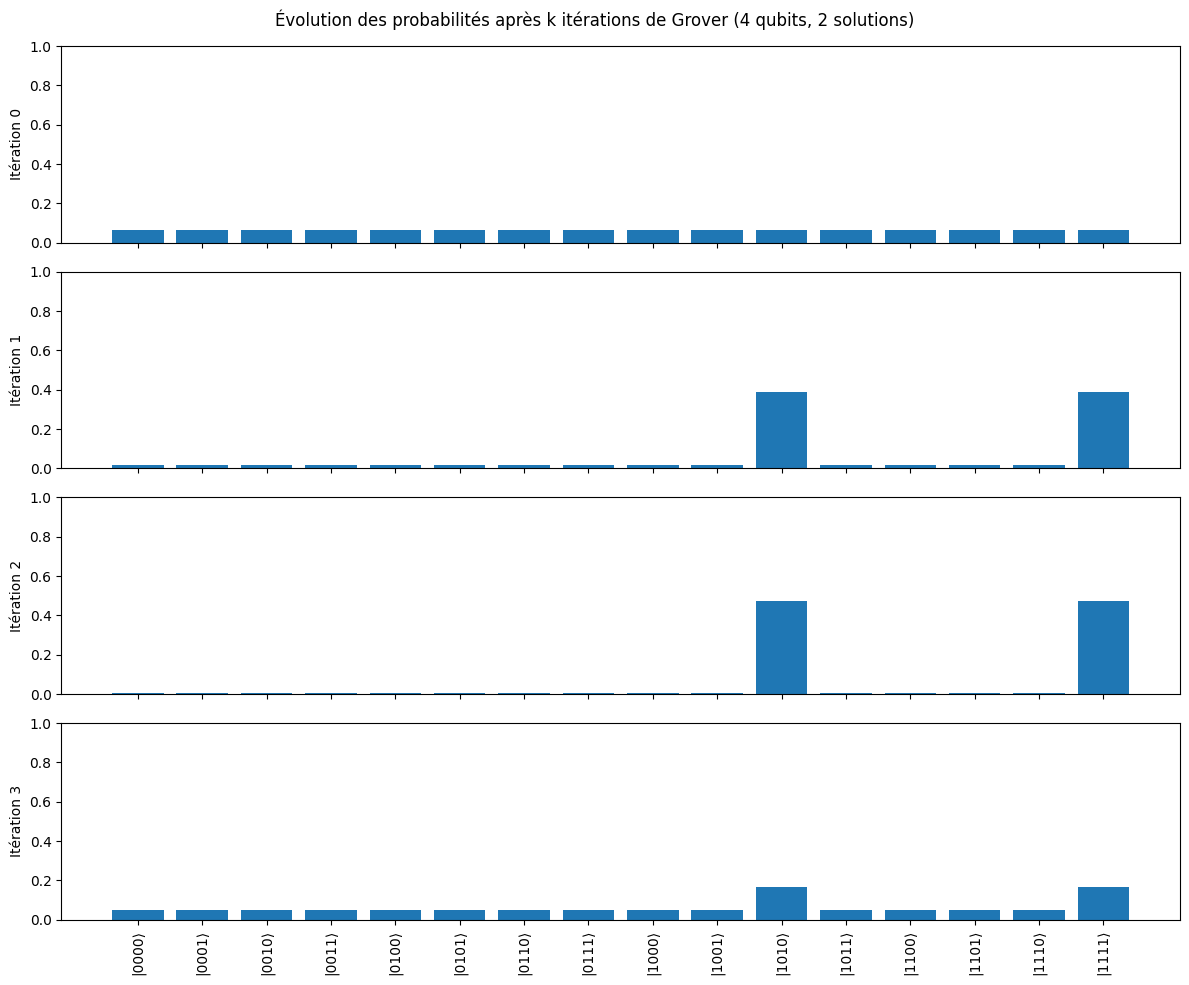

In [18]:
# Re-imports après reset
import numpy as np
import matplotlib.pyplot as plt

# --- Fonctions utilitaires ---
def apply_oracle(statevector, marked):
    """Applique l'oracle : change le signe des amplitudes des états marqués."""
    new_sv = np.array(statevector, dtype=complex)
    for m in marked:
        idx = int(m, 2)
        new_sv[idx] *= -1
    return new_sv

def apply_diffuser(statevector):
    """Applique le diffuseur : inversion par rapport à la moyenne."""
    mu = np.mean(statevector)
    return 2 * mu - statevector

# --- Initialisation : superposition uniforme sur 4 qubits ---
n = 4
psi0 = np.ones(2**n) / np.sqrt(2**n)

# États marqués
marked_states = ["1010", "1111"]

# Fonction pour exécuter k itérations de Grover
def grover_iterations(initial_state, marked, k):
    state = np.array(initial_state, dtype=complex)
    for _ in range(k):
        state = apply_oracle(state, marked)
        state = apply_diffuser(state)
    return state

# Préparer les amplitudes après 0,1,2,3 itérations
states_over_time = [grover_iterations(psi0, marked_states, k) for k in range(4)]

# Tracer les probabilités pour chaque itération
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

for k, state in enumerate(states_over_time):
    probs = np.abs(state) ** 2
    axes[k].bar(range(len(probs)), probs)
    axes[k].set_ylabel(f"Itération {k}")
    axes[k].set_ylim(0, 1)

axes[-1].set_xticks(range(16))
axes[-1].set_xticklabels([f"|{i:04b}⟩" for i in range(16)], rotation=90)
plt.suptitle("Évolution des probabilités après k itérations de Grover (4 qubits, 2 solutions)")
plt.tight_layout()
plt.show()
